Use XGBoost To Prediction Store Level Traffic
----------

V3.0

1. Use marketing calendar to replace finance calendar compared to V1.0.
2. Add more features

V3.1

1. Play around with marketing events/features

Benchmarks:
  - Clean_Daily_V31_APE_XGB_8_70_6_04
  ```python
  selected_event_names = ['KohlsCashEarn', 'KohlsCashRedeem', 'LTO', 'FriendsFamily', 'GPO', 
                       'AFFILIATE_ONLY', 'Associate_Shop', 'BC_Shopping_Pass', 'BMSM_1520_BC', 'BMSM_1520_KC', 
                       'BTS_10_50_GPO', 'Credit_Event', 'DirectMail_Support_Flag',
                        'Email_Mystery_Offer', 'GPO_CASP_15', 'GPO_CASP_20', 'GPO_CASP_25', 
                        'Loyalty_Triple_Points', 
                        'KC_Shopping_Pass', 'Merch_GPO', 'ONLINE_ONLY', 'PAD_MVC_Burg',
                        'Radio_Support_Flag', 'TV_Support_Flag', 'Tab_Support_Flag']
    {'n_estimators': 70, 'min_child_weight': 6, 'max_depth': 8, 'gamma': 0.4}
    fscl_mn_id   abs_ape
    0      201802  0.258207
    1      201803  0.148848
    2      201804  0.157783
    3      201805  0.091313
    4      201806  0.066403
    5      201807  0.083776
    6      201808  0.058400
    7      201809  0.000000
    8      201810  0.000000
    0.1344
    ```
    
  - Clean_Daily_V31_APE_XGB_9_70_3_03
  ```python
  selected_event_names = ['KohlsCashEarn', 'KohlsCashRedeem', 'LTO', 'FriendsFamily', 'GPO', 'AFFILIATE_ONLY', 'Associate_Shop', 'BC_Shopping_Pass', 'BMSM_1520_BC', 'BMSM_1520_KC', 'BTS_10_50_GPO', 'Credit_Event', 'DirectMail_Support_Flag', 'Email_Mystery_Offer', 'GPO_CASP_15', 'GPO_CASP_20', 'KC_Shopping_Pass', 'Merch_GPO', 'ONLINE_ONLY', 'PAD_MVC_Burg', 'Radio_Support_Flag', 'TV_Support_Flag', 'Tab_Support_Flag']
  {'n_estimators': 70, 'min_child_weight': 3, 'max_depth': 9, 'gamma': 0.3}
  fscl_mn_id   abs_ape
    0      201802  0.253237
    1      201803  0.171216
    2      201804  0.147859
    3      201805  0.086374
    4      201806  0.068320
    5      201807  0.082798
    6      201808  0.055965
    7      201809  0.000000
    8      201810  0.000000
    0.1350
  ```


In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
import math
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Solve problem with xgb error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Utility functions

def Prior_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 11
    elif mn == 2:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 2
    
def One_Month(fscl_mn_id):
    year = int(fscl_mn_id / 100)
    mn = fscl_mn_id % 100
    
    if mn == 1:
        return (year - 1) * 100 + 12
    else:
        return year * 100 + mn - 1
    
def GetAPE(x0, x1):
    if x0 == 0:
        return 0
    else:
        return round((x0 - x1) / x0, 4)

### Read in the marketing calendar and get the events

In [4]:
# Read in csv
calendar = pd.read_csv('../DataFromSOE/Mktg Promo/celect_mktg_promo_calendar.csv')

# Get data into string
calendar['trn_sls_dte'] = pd.to_datetime(calendar['Date'], infer_datetime_format=True)
calendar['Date'] = calendar['trn_sls_dte'].dt.strftime("%Y-%m-%d")

# Sort and select date range
calendar.sort_values('Date', inplace=True)
calendar = calendar[calendar['Date'] >= '2017-01-29']

In [5]:
calendar.tail(3)

,Date,Event_Type,Valentines_Day,Presidents_Day,Easter,Mothers_Day,Memorial_Day,Fathers_Day,Independence_Day,Labor_Day,...,YM_10_20_DM,YM_10_40_GPO,Merch_GPO,Tab_Kohls_at_Bottom,Tab_Kohls_Hidden,Tab_White_Background,Tab_Removed_Clear_BB_DB_Message,ONLINE_ONLY,AFFILIATE_ONLY,trn_sls_dte
2832,2018-11-01,Weekend,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,2018-11-01
2833,2018-11-02,Weekend,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,2018-11-02
2834,2018-11-03,Weekend,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,2018-11-03


In [6]:
# Check Null Values
# All the events have not missing values.

calendar.isnull().sum().sum()

0

In [7]:
# Check the unique values
# All the events have either 0 or 1.

pd.unique(calendar[calendar.columns.tolist()[2:-1]].values.ravel('K'))

array([0, 1])

In [8]:
# Get the number of events for each type of events

event_count = {}
event_count['Event'] = []
event_count['Count'] = []
for e in calendar.columns.tolist()[2:-1]:
    c = calendar[e].sum()
    event_count['Event'].append(e)
    event_count['Count'].append(c)
    
df_event = pd.DataFrame(event_count)
df_event.sort_values('Count', inplace=True, ascending=False)

# Select only events that are not all '0' or '1'
no_row = len(calendar)
df_event = df_event[(df_event['Count'] > 0) & (df_event['Count'] < no_row)]

In [9]:
# Some events have more sub events. So either include the event itself or include only the sub events.
# Separate the holiday here as I have a separate holiday dataset

has_sub_event = ['KohlsCashEarn', 'KohlsCashRedeem', 'LTO', 'FriendsFamily', 'GPO']
holiday_event = ['Valentines_Day', 'Presidents_Day', 'Easter', 'Mothers_Day', 'Memorial_Day',
                 'Fathers_Day', 'Independence_Day', 'Labor_Day', 'Columbus_Day', 'Halloween', 
                 'Veterans_Day', 'Thanksgiving', 'Christmas', 'New_Years', 'MLK_Day', 'Super_Bowl', 
                 'Hanukkah']

### Important: what events to be used.

In [10]:
event_names = [i for i in df_event.Event.unique().tolist() if i not in has_sub_event + holiday_event + 
              ['Date', 'Event_Type', 'trn_sls_dte']]

In [11]:
print('Number of events: %d'%(len(event_names)))
print(sorted(event_names))

Number of events: 72
['AFFILIATE_ONLY', 'Associate_Shop', 'BC_Shopping_Pass', 'BMSM_1520_BC', 'BMSM_1520_KC', 'BTS_10_50_GPO', 'Baby_10_30_GPO', 'CASP_10_25_BC', 'CASP_10_25_KC', 'CASP_10_30_BC', 'CASP_10_30_KC', 'CASP_10_50_BC', 'CASP_10_50_KC', 'CASP_15_BC', 'CASP_15_KC', 'CASP_20_BC', 'CASP_20_KC', 'CASP_25_BC', 'CASP_25_KC', 'Credit_Event', 'CuddlDuds_10_40_GPO', 'DirectMail_Support_Flag', 'Email_Mystery_20_30_40_percent', 'Email_Mystery_Offer', 'FathersDayJewelry_10_50_GPO', 'FathersDay_10_50_GPO', 'FriendsFamily_GPO_20', 'FriendsFamily_GPO_25', 'GPO_10_25', 'GPO_10_30', 'GPO_10_50', 'GPO_BMSM_1520', 'GPO_CASP_15', 'GPO_CASP_20', 'GPO_CASP_25', 'Home_10_50_GPO', 'Intimates_10_40_GPO', 'Intimates_10_50_GPO', 'Jewelry_10_50_GPO', 'Jewelry_20pt_GPO', 'Juniors_10_40_GPO', 'KC_Shopping_Pass', 'Kids_10_40_GPO', 'Kids_10_50_GPO', 'KohlsCashEarn_10_50', 'KohlsCashEarn_15_50', 'KohlsCashEarn_5_25', 'KohlsCashRedeem_10_50', 'KohlsCashRedeem_15_50', 'KohlsCashRedeem_5_25', 'LTO_25', 'LTO_30'

In [12]:
fin_event_names = ['BMSM_GPO', 'CASP_GPO', 'CASP_KCOnly', 'CASP_Limited', 'CE_KCOnly',
       'FF_GPO', 'FF_Limited', 'LPS_GPO', 'Pricing_GPO', 'Sale_GPO', 'Y2Y_GPO',
       'E23_MysteryOffer', 'E23_GPO', 'E23_Flash', 'E23_Category', 'E23_Sale',
       'E23_AssociateShop', 'E23_Booster', 'E23_KCSP', 'E23_BMSM', 'E23_PAD',
       'D23_GPO', 'D23_KCOnly', 'D23_Limited', 'D23_OnlineOnly']

selected_event_names = ['KohlsCashEarn', 'KohlsCashRedeem', 'LTO', 'FriendsFamily', 'GPO', 
                       'AFFILIATE_ONLY', 'Associate_Shop', 'BC_Shopping_Pass', 'BMSM_1520_BC', 'BMSM_1520_KC', 
                       'BTS_10_50_GPO', 'Credit_Event', 'DirectMail_Support_Flag',
                        'Email_Mystery_Offer', 'GPO_CASP_15', 'GPO_CASP_20', 'GPO_CASP_25', 
                        'Loyalty_Triple_Points', 
                        'KC_Shopping_Pass', 'Merch_GPO', 'ONLINE_ONLY', 'PAD_MVC_Burg',
                        'Radio_Support_Flag', 'TV_Support_Flag', 'Tab_Support_Flag']
not_to_include = ['GPO_CASP_25', 'Loyalty_Triple_Points']
event_names = [i for i in selected_event_names if i not in not_to_include]
print('Events to be included: ', event_names)

Events to be included:  ['KohlsCashEarn', 'KohlsCashRedeem', 'LTO', 'FriendsFamily', 'GPO', 'AFFILIATE_ONLY', 'Associate_Shop', 'BC_Shopping_Pass', 'BMSM_1520_BC', 'BMSM_1520_KC', 'BTS_10_50_GPO', 'Credit_Event', 'DirectMail_Support_Flag', 'Email_Mystery_Offer', 'GPO_CASP_15', 'GPO_CASP_20', 'KC_Shopping_Pass', 'Merch_GPO', 'ONLINE_ONLY', 'PAD_MVC_Burg', 'Radio_Support_Flag', 'TV_Support_Flag', 'Tab_Support_Flag']


In [13]:
calendar = calendar[['Date'] + event_names]

### Tuning and test for one store

In [14]:
# Flags

flag_clean = True
flag_hourly = False

In [15]:
# Define global variables
startdate_sales = '2017-01-29'
startdate_train = '2018-02-01'
startmonth_model = 201802

# Special Days
easter_days = ['2012-04-08', '2013-03-31', '2014-04-20', '2015-04-05', '2016-03-27', '2017-04-16', '2018-04-01']
christmas_days = ['2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25']
thanksgiving_days = ['2012-11-22', '2013-11-28', '2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22']

In [16]:
# Read in holiday

holiday = pd.read_csv('./StoreHourlyTrafficClean/holiday_DesignMatrix.csv')
holiday.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
# Read in Traffic

# Load sales, holiday, and calendar
store_id = 8

# "Sales" is Traffic here.
sales = pd.read_csv('./StoreHourlyTrafficCleanPrediction/HourTrafficCleanPredict_' + str(store_id) + '.csv')

if flag_clean:
    sales = pd.read_csv('../TrafficPredictionV1.1/StoreHourlyTrafficCleanPrediction/HourTrafficCleanPredict_' + str(store_id) + '.csv')
    sales['DTE_HR'] = pd.to_datetime(sales.Date + ' ' + sales['SALEHOUR'].astype('str') + ':00:00',
                                    infer_datetime_format=True)

    if 'VSTR_IN_CNT' in sales.columns.tolist():
        sales.drop('VSTR_IN_CNT', axis=1, inplace=True)

    sales.rename(columns={'IN_Clean':'VSTR_IN_CNT'}, inplace=True)

else:
    sales = pd.read_csv('../TrafficPredictionV1.1/StoreHourlyTraffic/HourlyTraffic_' + str(store_id) + '.csv')

# Treat the read in sales data differently if it's hourly or daily
if flag_hourly:
    # Get dummy variables for each hour.
    sales = sales.join(pd.get_dummies(sales.SALEHOUR, prefix='Hour'))

    # Create a datetime column.
    sales['trn_sls_dte'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)
    sales['Date'] = sales['trn_sls_dte'].dt.strftime('%Y-%m-%d')
    sales.sort_values(by=['Date', 'SALEHOUR'], inplace=True)
else:
    # If it's daily, aggregate the hours traffic into daily.
    sales = sales[['Date', 'VSTR_IN_CNT']].groupby('Date').agg(
        {'VSTR_IN_CNT': np.sum}).reset_index()

    # Sort sales DataFrame
    sales['trn_sls_dte'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)
    sales['Date'] = sales['trn_sls_dte'].dt.strftime('%Y-%m-%d')
    sales.sort_values('Date', inplace=True)

In [18]:
# Get rid of unwanted dates.
sales = sales[~(sales['Date'].isin(easter_days + christmas_days))]
sales = sales[sales['Date'] > startdate_sales]

# Get log sales and get rid of null sales date
sales['log_VSTR_IN_CNT'] = sales['VSTR_IN_CNT'].map(lambda x: math.log(x) if x != 0 else 0)
sales = sales[sales.VSTR_IN_CNT.notnull()]

sales['trn_sls_dte'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)
sales['fscl_mn_id'] = sales['trn_sls_dte'].dt.year * 100 + sales['trn_sls_dte'].dt.month

# Get the fscl_mn_id starting from startmonth_train until the last fscl_mn_id in the DataFrame.
fscls_list = sales.fscl_mn_id.unique().tolist() 
fscls = [i for i in fscls_list if i >= startmonth_model]

In [19]:
sales.tail(5)

,Date,VSTR_IN_CNT,trn_sls_dte,log_VSTR_IN_CNT,fscl_mn_id
635,2018-10-27,0.0,2018-10-27,0.0,201810
636,2018-10-28,0.0,2018-10-28,0.0,201810
637,2018-10-29,0.0,2018-10-29,0.0,201810
638,2018-10-30,0.0,2018-10-30,0.0,201810
639,2018-10-31,0.0,2018-10-31,0.0,201810


In [20]:
print('Total days are %d.'%(len(sales)))

Total days are 636.


In [21]:
# Align with Black Friday and view data

import datetime
datetime.date(2017, 11, 24)

df_2018 = sales[sales.trn_sls_dte.dt.year == 2018].copy()
df_2018.trn_sls_dte = df_2018.trn_sls_dte.map(lambda x: x.replace(year=2017) + datetime.timedelta(days=1))

df_2016 = sales[sales.trn_sls_dte.dt.year == 2016].copy()
df_2016.trn_sls_dte = df_2016.trn_sls_dte.map(lambda x: x.replace(year=2017) - datetime.timedelta(days=1))

In [22]:
if False:
    import plotly.plotly as py
    py.sign_in('justinnew','YqtA9aVcQqaZeCHN1YrG')
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(sales[(sales['Date'] >= '2017-01-01') & (sales['Date'] <= '2017-12-31')].trn_sls_dte, 
         sales[(sales['Date'] >= '2017-01-01') & (sales['Date'] <= '2017-12-31')].VSTR_IN_CNT,
        color='r')
    ax1.plot(df_2016.trn_sls_dte, df_2016.VSTR_IN_CNT, color='b')
    ax1.plot(df_2018.trn_sls_dte, df_2018.VSTR_IN_CNT, color='black')
    py.iplot_mpl(fig)

### Feature Engineering

In [23]:
def ToBlackFriday(x):
    
    if x.to_pydatetime().year == 2014:
        return (x.to_pydatetime() - datetime.datetime(2014, 11, 28)).days
    elif x.to_pydatetime().year == 2015:
        return (x.to_pydatetime() - datetime.datetime(2015, 11, 27)).days
    elif x.to_pydatetime().year == 2016:
        return (x.to_pydatetime() - datetime.datetime(2016, 11, 25)).days
    elif x.to_pydatetime().year == 2017:
        return (x.to_pydatetime() - datetime.datetime(2017, 11, 24)).days
    elif x.to_pydatetime().year == 2018:
        return (x.to_pydatetime() - datetime.datetime(2018, 11, 23)).days
    elif x.to_pydatetime().year == 2019:
        return (x.to_pydatetime() - datetime.datetime(2019, 11, 29)).days
    
def WeekBeforeLaborDay(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 9, 1)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 9, 7)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 9, 5)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 9, 4)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 9, 3)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 9, 2)).days
        
    if t >= -7 and t <= -1:
        return 1
    else:
        return 0
    
def WeekAfterBlackFriday(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 11, 28)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 11, 27)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 11, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 11, 24)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 11, 23)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 11, 29)).days
        
    if t >= 1 and t <= 9:
        return 1
    else:
        return 0
    
def WeekAfterChristmas(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 12, 25)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 12, 25)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 12, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 12, 25)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 12, 25)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 12, 25)).days
        
    if t >= 1 and t <= 6:
        return 1
    else:
        return 0
    
def WeekAfterNewYear(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 1, 1)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 1, 1)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 1, 1)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 1, 1)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 1, 1)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 1, 1)).days
        
    if t >= 1 and t <= 7:
        return 1
    else:
        return 0
    
def WeekBeforeChristmas1(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 12, 25)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 12, 25)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 12, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 12, 25)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 12, 25)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 12, 25)).days
        
    if t >= -7 and t <= -1:
        return 1
    else:
        return 0

def WeekBeforeChristmas2(x):
    
    if x.to_pydatetime().year == 2014:
        t = (x.to_pydatetime() - datetime.datetime(2014, 12, 25)).days
    elif x.to_pydatetime().year == 2015:
        t = (x.to_pydatetime() - datetime.datetime(2015, 12, 25)).days
    elif x.to_pydatetime().year == 2016:
        t = (x.to_pydatetime() - datetime.datetime(2016, 12, 25)).days
    elif x.to_pydatetime().year == 2017:
        t = (x.to_pydatetime() - datetime.datetime(2017, 12, 25)).days
    elif x.to_pydatetime().year == 2018:
        t = (x.to_pydatetime() - datetime.datetime(2018, 12, 25)).days
    elif x.to_pydatetime().year == 2019:
        t = (x.to_pydatetime() - datetime.datetime(2019, 12, 25)).days
        
    if t >= -14 and t <= -8:
        return 1
    else:
        return 0
    
ChristmasShopDay = ['2014-12-23', '2015-12-23', '2016-12-23', '2017-12-23', '2018-12-23', '2019-12-23']
sales['ChristShopDay'] = sales['Date'].map(lambda x: 1 if x in ChristmasShopDay else 0)
sales['ToBlackFriday'] = sales['trn_sls_dte'].map(lambda x: ToBlackFriday(x))
sales['WeekBeforeLaborDay'] = sales['trn_sls_dte'].map(lambda x: WeekBeforeLaborDay(x))
sales['WeekAfterBlackFriday'] = sales['trn_sls_dte'].map(lambda x: WeekAfterBlackFriday(x))
sales['WeekAfterChristmas'] = sales['trn_sls_dte'].map(lambda x: WeekAfterChristmas(x))
sales['WeekAfterNewYear'] = sales['trn_sls_dte'].map(lambda x: WeekAfterNewYear(x))
sales['WeekBeforeChristmas1'] = sales['trn_sls_dte'].map(lambda x: WeekBeforeChristmas1(x))
sales['WeekBeforeChristmas2'] = sales['trn_sls_dte'].map(lambda x: WeekBeforeChristmas2(x))
sales['Weekday'] = sales['trn_sls_dte'].dt.weekday
sales['Month'] = sales['trn_sls_dte'].dt.month
sales = sales.join(pd.get_dummies(sales.Weekday, prefix='Weekday'))
sales = sales.join(pd.get_dummies(sales.Month, prefix='Month'))

In [24]:
# Define holiday names

holiday_names = ['MemorialDay', 'IndependenceDay', 'LaborDay', 'ColumbusDay', 'BlackFriday', 'NewYearsDay', 
                 'ChristmasDay', 'VeteransDay', 'Halloween', 'CyberMonday', 'GreenMonday', 'MLKJrDay', 
                 'PresidentsDay', 'NewYearsEve']

In [25]:
sales.columns

Index(['Date', 'VSTR_IN_CNT', 'trn_sls_dte', 'log_VSTR_IN_CNT', 'fscl_mn_id',
       'ChristShopDay', 'ToBlackFriday', 'WeekBeforeLaborDay',
       'WeekAfterBlackFriday', 'WeekAfterChristmas', 'WeekAfterNewYear',
       'WeekBeforeChristmas1', 'WeekBeforeChristmas2', 'Weekday', 'Month',
       'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4',
       'Weekday_5', 'Weekday_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12'],
      dtype='object')

In [26]:
# Use different features for hourly or daily prediction.
if flag_hourly:
    day_names = ['Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
             'Month_1', 'ChristShopDay', 'WeekBeforeLaborDay', 'WeekAfterBlackFriday', 'WeekAfterChristmas',
             'WeekAfterNewYear', 'WeekBeforeChristmas1', 'WeekBeforeChristmas2', 'ToBlackFriday',
             'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7',
             'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
             'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
             'Hour_22', 'Hour_23']

    # Join sales, holiday and calendar DataFrames together.
    sales = sales[['Date', 'fscl_mn_id', 'SALEHOUR', 'DTE_HR', 'VSTR_IN_CNT'] +
                  day_names].merge(holiday, on='Date')
    sales = sales.merge(calendar, on='Date')

    # Get the sales DataFrame ready.
    sales = sales[['Date', 'fscl_mn_id', 'SALEHOUR', 'DTE_HR', 'VSTR_IN_CNT'] +
                  holiday_names + event_names + day_names]

else:
    day_names = ['Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
                 'Month_1', 'ChristShopDay', 'WeekBeforeLaborDay', 'WeekAfterBlackFriday', 'WeekAfterChristmas',
                 'WeekAfterNewYear', 'WeekBeforeChristmas1', 'WeekBeforeChristmas2', 'ToBlackFriday']

    # Join sales, holiday and calendar DataFrames together.
    sales = sales[['Date', 'fscl_mn_id', 'VSTR_IN_CNT'] + day_names].merge(holiday, on='Date')
    sales = sales.merge(calendar, on='Date')

    # Get the sales DataFrame ready.
    sales = sales[['Date', 'fscl_mn_id', 'VSTR_IN_CNT'] + holiday_names + event_names + day_names]

In [27]:
# Features
feature_cols = holiday_names + event_names + day_names

### Hyperparameter Tuning

In [28]:
# Reset index, otherwise there is problem with my own CViterator

sales.reset_index(inplace=True)
sales.drop('index', axis=1, inplace=True)

myCViterator = []
for time_filter in [201802, 201803, 201804, 201805, 201806, 201807]:
    prior_mn = One_Month(time_filter)
    trainIndices = sales[sales.fscl_mn_id <= prior_mn].index.values.astype(int)
    testIndices =  sales[sales.fscl_mn_id == time_filter].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )

In [29]:
dummy = [{'log_diff':0, 'pred':0}]
df_pred_all = pd.DataFrame(dummy)

flag_log = False
flag_model = 'xgb' # 'xgb' or 'rf'
flag_search = 'random' # 'grid' or 'random'

time_filter = 201807

# Get prior_mn and test_mn
prior_mn = One_Month(time_filter)

# Get train, test and predict DataFrame
train_data = sales[feature_cols]
predict_data = sales[sales.fscl_mn_id == time_filter][feature_cols]

if flag_log:
    train_label = sales['log_VSTR_IN_CNT']
    predict_label = sales[sales.fscl_mn_id == time_filter]['log_VSTR_IN_CNT']
else:
    train_label = sales['VSTR_IN_CNT']
    predict_label = sales[sales.fscl_mn_id == time_filter]['VSTR_IN_CNT']

# Define Model Parameters    
xgb = XGBRegressor(n_jobs=-1, silent=1, subsample=0.9, eval_metric='rmse')    
rf = RandomForestRegressor(n_jobs=-1)

if flag_model == 'xgb': 
    model = xgb
    params_grid = {
        "max_depth" : [3, 4, 5, 6, 7],
        "n_estimators": [20, 40, 60, 80, 100, 120, 140],
        "min_child_weight": [1, 3, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
    params_random = {
        "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9],
        "n_estimators": [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
        "min_child_weight": [1, 2, 3, 4, 5, 6],
        "gamma": [i/10.0 for i in range(3,6)]
         }
else:
    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae'
     }
    
if flag_search == 'grid':
    grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=myCViterator)
else:
    grid = RandomizedSearchCV(estimator=model, param_distributions=params_random, cv=myCViterator)

grid.fit(train_data, train_label)

print(grid.best_params_)

# Get prediction for each of the month
ypred = grid.best_estimator_.predict(predict_data)
df_pred_t = pd.DataFrame(predict_label)
df_pred_t = df_pred_t.assign(pred=list(ypred))

# Union to get all for each of the fscl_mn_id
df_pred_all = pd.concat([df_pred_all, df_pred_t])
    
# After prediction for all the month, get all APE and MAPE.
df_predict = sales[sales.fscl_mn_id >= startmonth_model]
df_predict = df_predict[['Date', 'fscl_mn_id', 'VSTR_IN_CNT']]
df_predict = df_predict.join(df_pred_all['pred'], how='left')

if flag_log:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred'].map(lambda x: math.exp(x))
else:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred']
    
df_predict['ape'] = df_predict[['VSTR_IN_CNT', 'VSTR_IN_CNT_pred']].apply(lambda x: GetAPE(x[0], x[1]), axis=1)
df_predict['abs_ape'] = df_predict['ape'].map(lambda x: abs(x))

# Save APE and MAPE to file
if flag_log:
    ape_file = './APE_MAPE_Log/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE_Log/Error_MAPE_' + str(store_id) + '.csv'
    if not os.path.exists('./APE_MAPE_Log'):
        os.mkdir('./APE_MAPE_Log')
else:
    ape_file = './APE_MAPE/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE/Error_MAPE_' + str(store_id) + '.csv'
    if not os.path.exists('./APE_MAPE'):
        os.mkdir('./APE_MAPE')  
    
df_predict.to_csv(ape_file)
df_mape = df_predict[['fscl_mn_id', 'abs_ape']].groupby('fscl_mn_id').agg({'abs_ape':np.mean}).reset_index()
df_mape.to_csv(mape_file)

print(df_mape)

{'n_estimators': 80, 'min_child_weight': 2, 'max_depth': 7, 'gamma': 0.5}
   fscl_mn_id   abs_ape
0      201802       NaN
1      201803       NaN
2      201804       NaN
3      201805       NaN
4      201806       NaN
5      201807  0.051674
6      201808  0.000000
7      201809  0.000000
8      201810  0.000000


### Get benchmarks

In [30]:
for time_filter in fscls:
    # Get prior_mn and test_mn
    prior_mn = Prior_Month(time_filter)
    
    # Get train, test and predict DataFrame
    train_data = sales[sales.fscl_mn_id <= prior_mn][feature_cols]
    predict_data = sales[sales.fscl_mn_id == time_filter][feature_cols]
    
    if flag_log:
        train_label = sales[sales.fscl_mn_id <= prior_mn]['log_VSTR_IN_CNT']
        predict_label = sales[sales.fscl_mn_id == time_filter]['log_VSTR_IN_CNT']
    else:
        train_label = sales[sales.fscl_mn_id <= prior_mn]['VSTR_IN_CNT']
        predict_label = sales[sales.fscl_mn_id == time_filter]['VSTR_IN_CNT']
        
    grid.best_estimator_.fit(train_data, train_label)
    
    # Get prediction for each of the month
    ypred = grid.best_estimator_.predict(predict_data)
    df_pred_t = pd.DataFrame(predict_label)
    df_pred_t = df_pred_t.assign(pred=list(ypred))
    
    # Union to get all for each of the fscl_mn_id
    df_pred_all = pd.concat([df_pred_all, df_pred_t])
    
# After prediction for all the month, get all APE and MAPE.
df_predict = sales[sales.fscl_mn_id >= startmonth_model]
df_predict = df_predict[['Date', 'fscl_mn_id', 'VSTR_IN_CNT']]
df_predict = df_predict.join(df_pred_all['pred'], how='left')

if flag_log:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred'].map(lambda x: math.exp(x))
else:
    df_predict['VSTR_IN_CNT_pred'] = df_predict['pred']
    
df_predict['ape'] = df_predict[['VSTR_IN_CNT', 'VSTR_IN_CNT_pred']].apply(lambda x: GetAPE(x[0], x[1]), axis=1)
df_predict['abs_ape'] = df_predict['ape'].map(lambda x: abs(x))

# Save APE and MAPE to file
if flag_log:
    ape_file = './APE_MAPE_Log/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE_Log/Error_MAPE_' + str(store_id) + '.csv'
else:
    ape_file = './APE_MAPE/Error_APE_' + str(store_id) + '.csv'
    mape_file = './APE_MAPE/Error_MAPE_' + str(store_id) + '.csv'
    
df_predict.to_csv(ape_file)
df_mape = df_predict[['fscl_mn_id', 'abs_ape']].groupby('fscl_mn_id').agg({'abs_ape':np.mean}).reset_index()
df_mape.to_csv(mape_file)

print(df_mape)
print('%.4f'%(np.mean(df_mape[df_mape['fscl_mn_id'].isin([201802, 
                            201803, 201804, 201805, 201806, 201807])].abs_ape)))

   fscl_mn_id   abs_ape
0      201802  0.301552
1      201803  0.159213
2      201804  0.147624
3      201805  0.086029
4      201806  0.061430
5      201807  0.082016
6      201808  0.053503
7      201809  0.000000
8      201810  0.000000
0.1396


In [31]:
# Get feature scores.

# importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
fscore = grid.best_estimator_.get_booster().get_score(importance_type='gain')

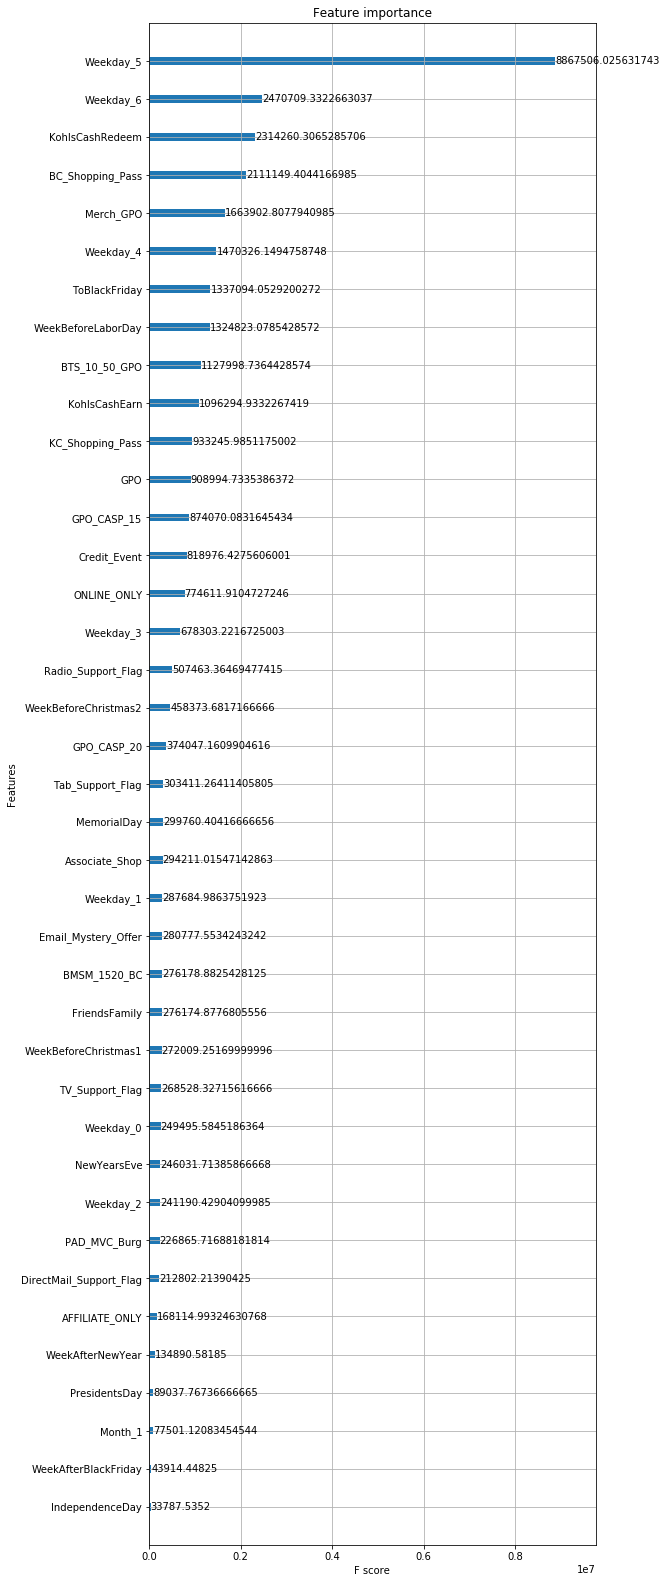

In [32]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax, importance_type='gain')
plt.show()

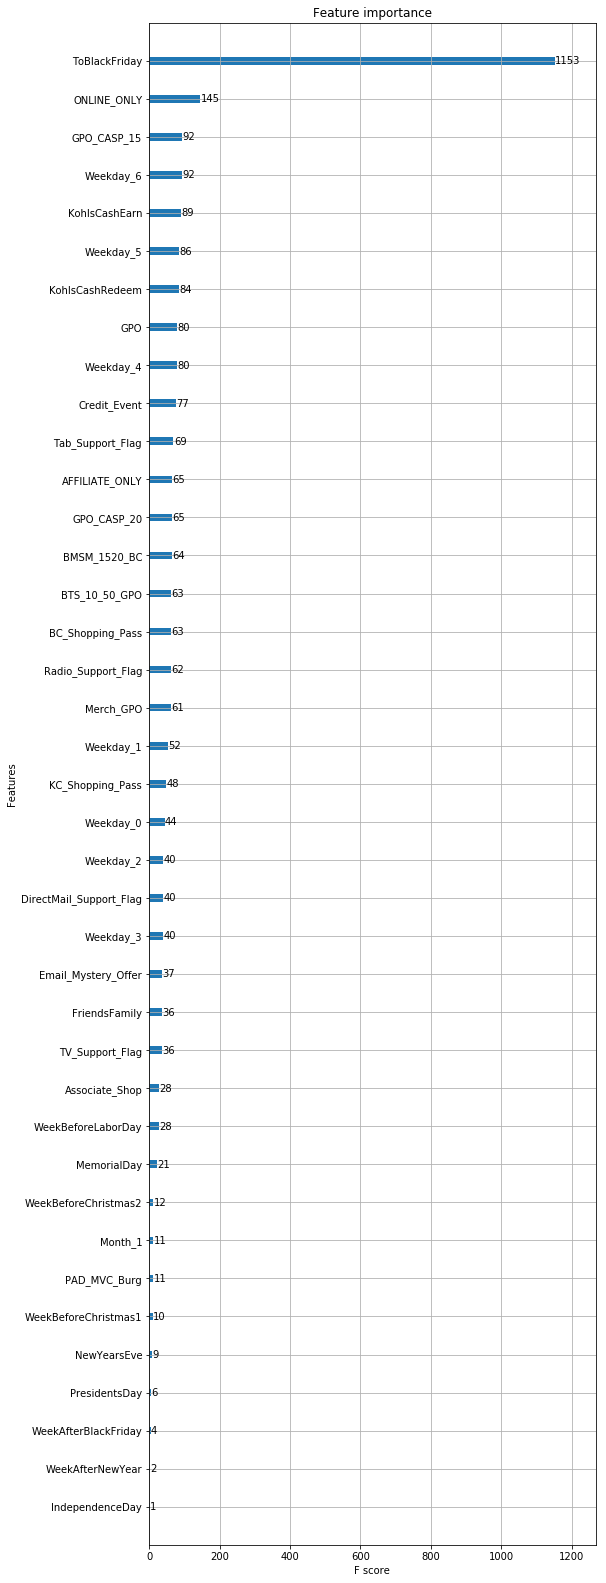

In [33]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax)
plt.show()

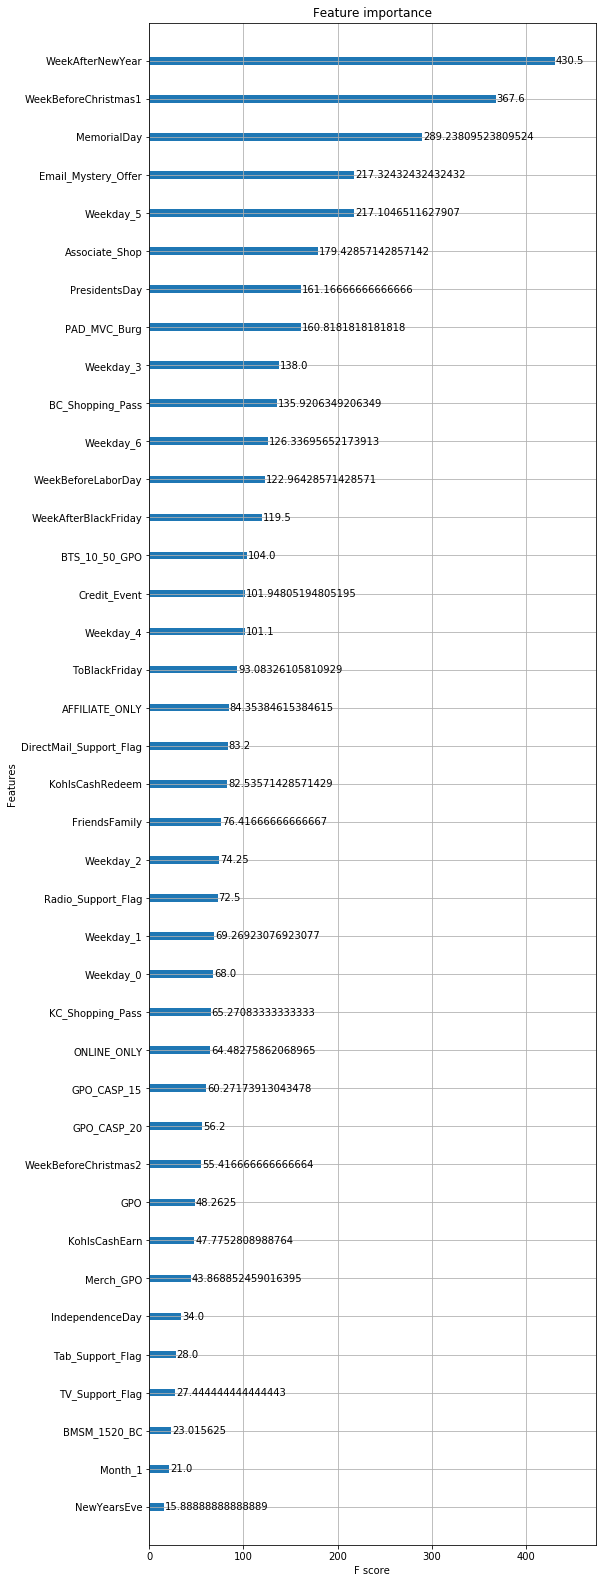

In [34]:
fig = plt.figure(figsize=(8,28))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax, importance_type='cover')
plt.show()

In [35]:
fscore

{'AFFILIATE_ONLY': 168114.99324630768,
 'Associate_Shop': 294211.01547142863,
 'BC_Shopping_Pass': 2111149.4044166985,
 'BMSM_1520_BC': 276178.8825428125,
 'BTS_10_50_GPO': 1127998.7364428574,
 'Credit_Event': 818976.4275606001,
 'DirectMail_Support_Flag': 212802.21390425,
 'Email_Mystery_Offer': 280777.5534243242,
 'FriendsFamily': 276174.8776805556,
 'GPO': 908994.7335386372,
 'GPO_CASP_15': 874070.0831645434,
 'GPO_CASP_20': 374047.1609904616,
 'IndependenceDay': 33787.5352,
 'KC_Shopping_Pass': 933245.9851175002,
 'KohlsCashEarn': 1096294.9332267419,
 'KohlsCashRedeem': 2314260.3065285706,
 'MemorialDay': 299760.40416666656,
 'Merch_GPO': 1663902.8077940985,
 'Month_1': 77501.12083454544,
 'NewYearsEve': 246031.71385866668,
 'ONLINE_ONLY': 774611.9104727246,
 'PAD_MVC_Burg': 226865.71688181814,
 'PresidentsDay': 89037.76736666665,
 'Radio_Support_Flag': 507463.36469477415,
 'TV_Support_Flag': 268528.32715616666,
 'Tab_Support_Flag': 303411.26411405805,
 'ToBlackFriday': 1337094.052